# **Project: Document Scanning for Book Pages**

[[ 385  156]
 [ 397 4607]
 [3167 4448]
 [3315  306]]


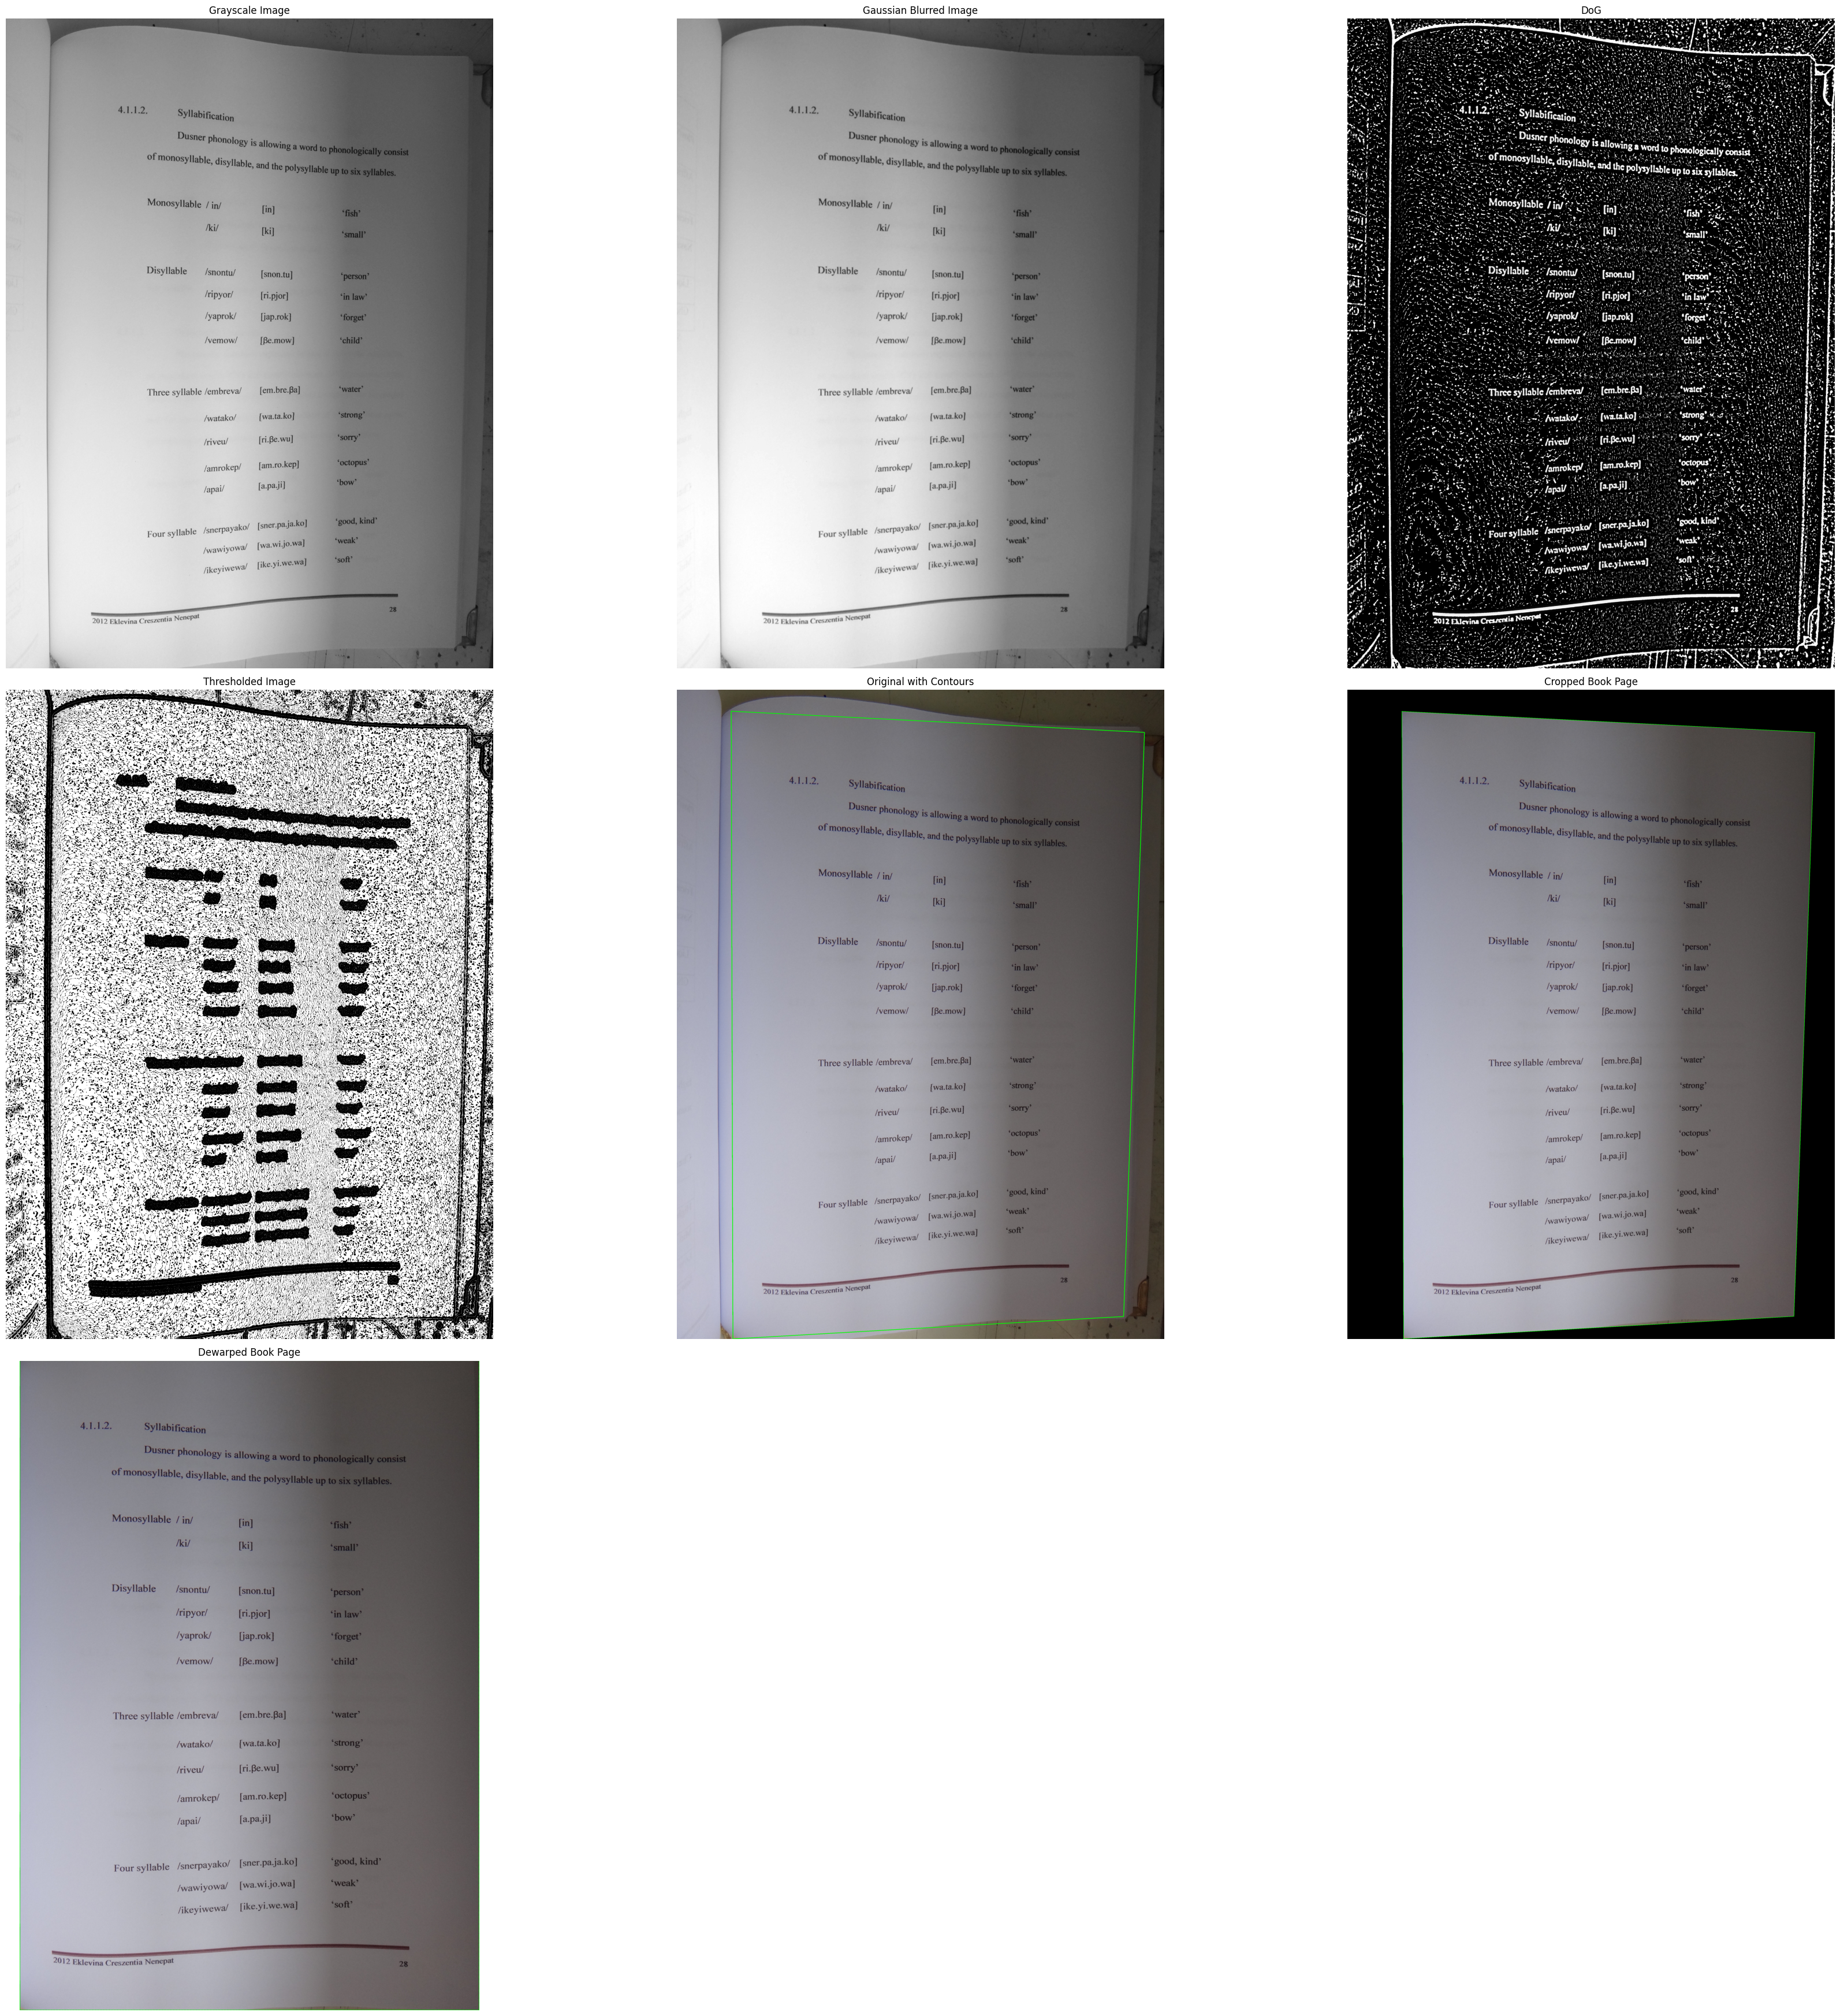

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

figSize = 35

# Load the image
image = cv2.imread('linguistics_thesis_a.jpg')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Plot the original grayscale image
plt.figure(figsize=(figSize, figSize))
plt.subplot(3, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (11, 11), 0)

# Plot the blurred image
plt.subplot(3, 3, 2)
plt.imshow(blurred, cmap='gray')
plt.title("Gaussian Blurred Image")
plt.axis('off')

# Use Difference of Gaussians (DoG) for blob detection
# Gaussian filter 1
gaussian1 = cv2.GaussianBlur(blurred, (21, 21), 0)
# Gaussian filter 2
gaussian2 = cv2.GaussianBlur(blurred, (51, 51), 0)

# DoG
dog = gaussian1 - gaussian2

# Plot the Difference of Gaussians result
plt.subplot(3, 3, 3)
plt.imshow(dog, cmap='gray')
plt.title("DoG")
plt.axis('off')

# Threshold DoG for blobs
_, thresh = cv2.threshold(dog, 0, 255, cv2.THRESH_BINARY_INV + cv2.ADAPTIVE_THRESH_MEAN_C)

# Plot the thresholded image
plt.subplot(3, 3, 4)
plt.imshow(thresh, cmap='gray')
plt.title("Thresholded Image")
plt.axis('off')

# Contours for blobs
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area (to find the largest one, which is likely the page)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Loop through contours and select the largest (book page)
for contour in contours:
    # Approximate the contour and check if it forms a rectangular shape
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # If the contour has 4 points, it is likely the book page
    if len(approx) == 4:
        book_page_contour = approx
        break

# Draw the contour of the book page on the original image
cv2.drawContours(image, [book_page_contour], -1, (0, 255, 0), 3)

# Plot the image with the contour of the book page
plt.subplot(3, 3, 5)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original with Contours")
plt.axis('off')

# Crop the book page region from the image
mask = np.zeros(gray.shape, dtype=np.uint8)
cv2.drawContours(mask, [book_page_contour], -1, 255, -1)
book_page = cv2.bitwise_and(image, image, mask=mask)

# Plot the cropped book page
plt.subplot(3, 3, 6)
plt.imshow(cv2.cvtColor(book_page, cv2.COLOR_BGR2RGB))
plt.title("Cropped Book Page")
plt.axis('off')

# ================== Page Dewarping ==================

print(book_page_contour)

# the points where weirdly saved in a complicated matrix, this makes it simple to work with.
flattened_book_page_points = book_page_contour.reshape(-1, 2)

print(flattened_book_page_points)

# prepare the sorted points list [Top_l, Top_r, Bottom_l, Bottom_right]
sorted_page_points = flattened_book_page_points.reshape(4,2)

input_points = np.zeros((4,2), dtype="float32")

# sorting the 4 points (biggest counters found from before), to be able to know which is top right, top left ect...
points_sum = sorted_page_points.sum(axis=1)
input_points[0] = sorted_page_points[np.argmin(points_sum)]
input_points[3] = sorted_page_points[np.argmax(points_sum)]

points_diff = np.diff(sorted_page_points, axis=1)

input_points[1] = sorted_page_points[np.argmin(points_diff)]
input_points[2] = sorted_page_points[np.argmax(points_diff)]

#unpack
(top_left, top_right, bottom_right, bottom_left) = input_points


# calculate distance between the 4 points to find the respective width and height of the image
bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

# output image size
max_width = max(int(bottom_width), int(top_width))

# max_height = max(int(right_height), int(left_height))
max_height = int(max_width * 1.414)  # for A4

# output image dimensions
converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

# perspective transformation
matrix = cv2.getPerspectiveTransform(input_points, converted_points)


# apply the perspective warp to dewarp the book page
dewarped_page = cv2.warpPerspective(book_page, matrix, (max_width, max_height))

# Plot the dewarped book page
plt.subplot(3, 3, 7)
plt.imshow(cv2.cvtColor(dewarped_page, cv2.COLOR_BGR2RGB))
plt.title("Dewarped Book Page")
plt.axis('off')

# Show all the images
plt.tight_layout()
plt.show()

